# Deutsch Jozsa (DJ) algorithm - quantum computing practice/toy problem
The deutsch jozsa algorithm determines if a given function f(x) which accepts x, an n-bit input, is constant or balanced.

**Classical**
* In the worst case scenario, a classical computer will have an O(2^n) runtime since it will have to compute every input combination in the case that f(x) is constant.
* In the best case scenario, a classical computer will need only compute two inputs in the case that f(x) is balanced and the second output differs from the first. (In most cases, we won't be this lucky)

**Quantum**
* A quantum computer will have a constant O(1) runtime for all values of n, since it can determine the probability of f(x) returning 1 or 0 in a single iteration of the DJ algorithm.
* However, due to the unreliability of qubits, this algorithm should be re-run many times to increase accuracy. (unlike classical computers quantum computers are prone to errors)

In [1]:
# Qiskit stuff
import qiskit
from qiskit import QuantumCircuit, transpile, generate_preset_pass_manager, ClassicalRegister, QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram

# Normal python stuff
import numpy as np

print(qiskit.__version__)

2.1.0


### Randomize the if f(x) is constant or balanced
* oracleType: 0 is constant f(x) and 1 is balanced f(x)
* oracleValue: the value outputted by the constant version of f(x)

In [13]:
# Randomize the if f(x) is constant or balanced
oracleType = np.random.randint(0, 2)
oracleValue = np.random.randint(0, 2)
n = 8 # Number of qubits, 23 is the max that can be reasonably run on a quantum simulator

if oracleType == 0:
    print("The oracle returns a constant value of", oracleValue)
else:
    print("The oracle is a balanced function")
    a = np.random.randint(1, 2**n) # parameter used later for balanced oracle only

The oracle returns a constant value of 1


## Build the quantum circuit

In [14]:
# Initialize the quantum circuit
quantum_register = QuantumRegister(n+1) # Quantum register needs n + 1 qubits for the output of f(x)
classical_register = ClassicalRegister(n)
circuit_name = "DJ"
circuit = QuantumCircuit(quantum_register, classical_register, name=circuit_name)

# Initialize the last qubit to |1> by negating it
circuit.x(quantum_register[n])

# Apply Hadamard gate to all qubits
for i in range(n + 1):
    circuit.h(quantum_register[i])

circuit.barrier()

if oracleType == 0:
    if oracleValue == 0:
        circuit.id(quantum_register[n]) # if the function is constant at 0, apply the identity to the last qubit
    else:
        circuit.x(quantum_register[n])  # if the function is constant at 1, negate the last qubit
else:
    for i in range(n):
        if a & (1 << i): # check if the i-th bit in the randomly generated value, a, is 1
            circuit.cx(quantum_register[i], quantum_register[n]) # CX is controlled NOT gate (CNOT), negating the second input only if the first input is true (1)

circuit.barrier()

# Apply Hadamard gate to all qubits
for i in range(n):
    circuit.h(quantum_register[i]) 

circuit.barrier()

# Measure result and store it in the classical register
for i in range(n):
    circuit.measure(quantum_register[i], classical_register[i])

## Quantum Circuit diagram

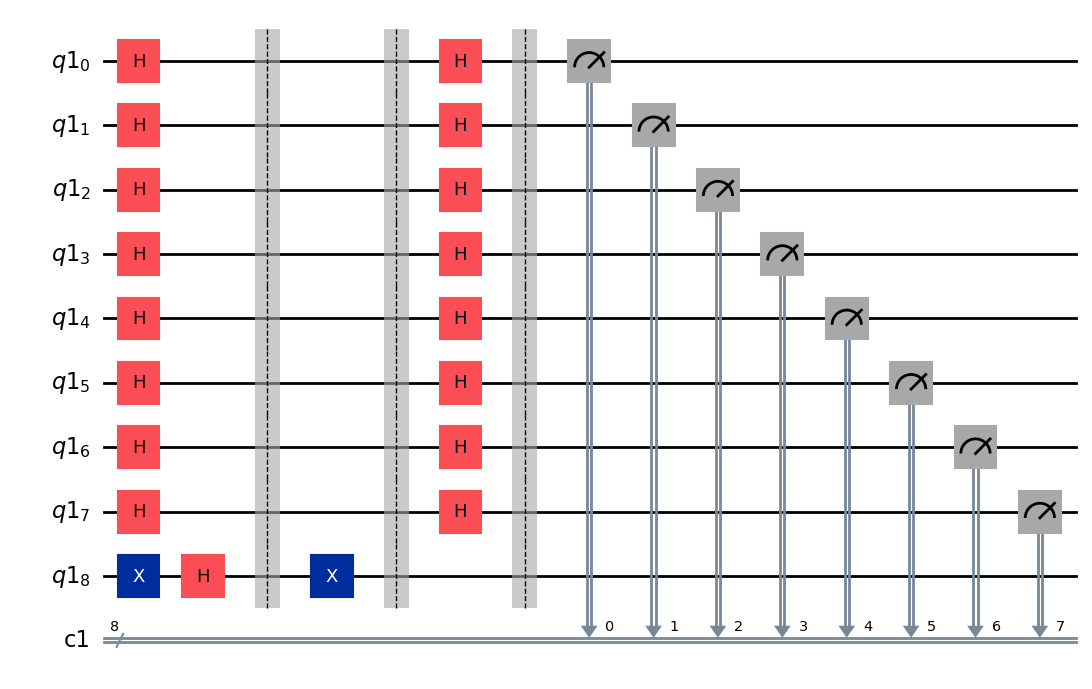

In [15]:
circuit.draw(output="mpl", scale=1)

In [16]:
def plot_results(results, shots):
    threshold = int(0.01 * shots) # only plot states that occur for at least 1% of the shots
    filtered_answer = { k: v for k, v in results.items() if v >= threshold }

    removed_counts = np.sum([ v for k, v in results.items() if v < threshold ])
    filtered_answer["other_bitstrings"] = removed_counts

    return plot_histogram(filtered_answer)

In [17]:
# Run the algorithm multiple times to account for noise
shots = 1000

## Simulator Result

In [18]:
simulator = GenericBackendV2(num_qubits=n+1, noise_info=True) # Simulator can simulate random noise that causes errors in real quantum computers

transpiled_circuit = transpile(circuits=circuit, backend=simulator, optimization_level=3)
job = simulator.run(transpiled_circuit, shots=shots)
result = job.result()

simulator_answer = result.get_counts()

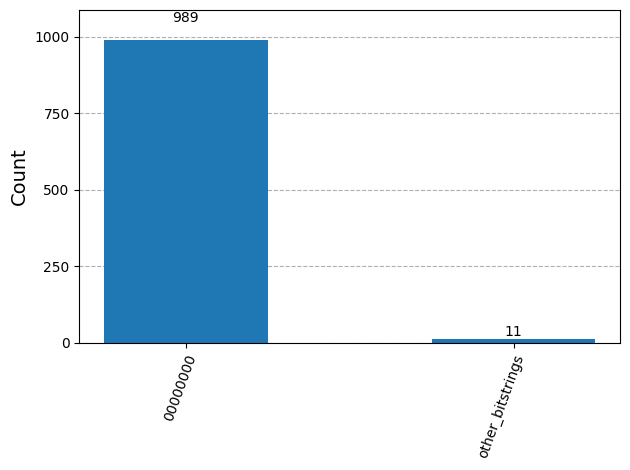

In [19]:
plot_results(simulator_answer, shots=shots)

## Quantum Computer Result

In [20]:
from dotenv import load_dotenv
import os

# Login to IBM Qauntum Cloud Platform

load_dotenv()
apikey = os.getenv("API_KEY")

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=apikey
)

C:\Users\Chris\AppData\Local\Temp\ipykernel_7036\3530905661.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


In [21]:
quantum_backend = service.least_busy(operational=True, simulator=False) # get least busy backend
print("Using backend:", quantum_backend.name)

pm = generate_preset_pass_manager(backend=quantum_backend, optimization_level=3)
isa_circuit = pm.run(circuit)

sampler = SamplerV2(mode=quantum_backend)
job = sampler.run([isa_circuit], shots=1000)
result = job.result()[0]

Using backend: ibm_brisbane


c:\Dev\Quantum-DeutschJosza-Algo\.venv\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


{'00000000': 952, '00000001': 4, '00000010': 12, '01000000': 6, '00100000': 7, '10000000': 6, '00010000': 6, '00000100': 4, '00001000': 3}
9


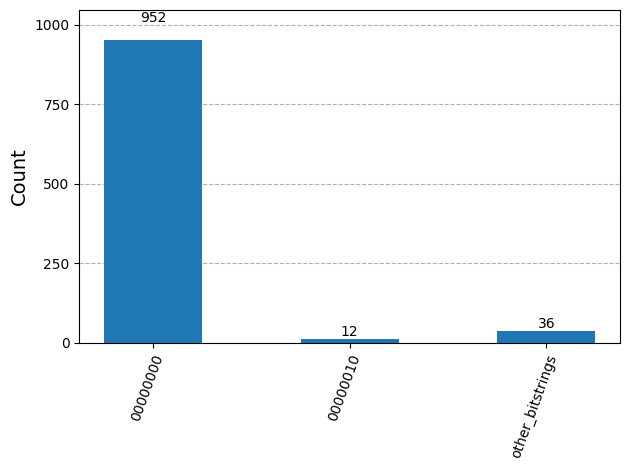

In [22]:
true_quantum_result = list(result.data.values())[0].get_counts() # Extract the counts from the sampler result
print(true_quantum_result)
print(len(true_quantum_result))
plot_results(true_quantum_result, shots)

## Credits to the following resources and guides used to create this notebook

* https://quantum.ibm.com/
* https://docs.quantum.ibm.com/
* https://www.youtube.com/watch?v=7MdEHsRZxvo
* https://www.youtube.com/watch?v=WifWdbXjG00
* https://www.youtube.com/watch?v=JOJ5zihcd6Q
* https://www.youtube.com/watch?v=RQWpF2Gb-gU